# DeePMD-kit Handson Tutorial


DeePMD-kit is a deep learning package for many-body potential energy representation and molecular dynamics. 

This tutorial can direct run on **Bohrium Notebook** . You can click the above blue button `connect`, choose `bohrium-notebook:2023-03-26` as image and `c8_m16_cpu` as computing resources. 

Wait a minute and you can get started.

If you have any questions, you can contact *bohrium@dp.tech* for help. 


## Table of contents
* Get tutorial data via git
* General Introduction
* Data preparation
* Prepare input script
* Train a model
* Freeze a model
* Test a model
* Run MD with LAMMPS (not in this tutorial)


## Get tutorial data via git

In [18]:
! if ! [ -e colombo-academy-tutorials ];then git clone https://gitee.com/deepmodeling/colombo-academy-tutorials.git;fi;

Cloning into 'colombo-academy-tutorials'...
remote: Enumerating objects: 7141, done.
remote: Counting objects: 100% (151/151), done.
remote: Compressing objects: 100% (117/117), done.
remote: Total 7141 (delta 77), reused 49 (delta 30), pack-reused 6990
Receiving objects: 100% (7141/7141), 41.63 MiB | 3.47 MiB/s, done.
Resolving deltas: 100% (3377/3377), done.
Updating files: 100% (162/162), done.


## General Introduction
This tutorial will introduce you to the basic usage of the DeePMD-kit, taking a gas phase methane molecule as an example. [DeePMD-kit's document](https://docs.deepmodeling.org/projects/deepmd/en/master/index.html 
) is recommended as the complete reference.

The DP model is generated using the DeePMD-kit package (v2.1.5). The training data is converted into the format of DeePMD-kit using a tool named dpdata (v0.2.14). 

Details of dpdata and DeePMD-kit installation and execution of can be found in [the DeepModeling official GitHub site](https://github.com/deepmodeling). 

We've prepared initial data for CH4 for you, and put them in the folder `colombo-academy-tutorials/DeePMD-kit/00.data`

In [19]:
import os
prefix_path = os.getcwd()

Folder `abacus_md` is obtained by performing ab-initio molecular dynamics with ABACUS. Detailed instructions on ABACUS can be found in its [document](https://abacus.deepmodeling.com/en/latest/). 

In [20]:
os.chdir(os.path.join(prefix_path, "colombo-academy-tutorials", "DeePMD-kit", "00.data"))
os.listdir("abacus_md")

['C_ONCV_PBE-1.2.upf',
 'C_gga_6au_100Ry_2s2p1d.orb',
 'H_ONCV_PBE-1.2.upf',
 'H_gga_6au_100Ry_2s1p.orb',
 'INPUT',
 'KPT',
 'OUT.ABACUS',
 'STRU']

## Data preparation
The training data of the DeePMD-kit contains the atom type, the simulation box, the atom coordinate, the atom force, the system energy, and the virial. A snapshot of a molecular system that has this information is called a frame. A system of data includes many frames that share the same number of atoms and atom types. For example, a molecular dynamics trajectory can be converted into a system of data, with each time step corresponding to a frame in the system.

We provide a convenient tool named dpdata for converting the data produced by CP2K, Gaussian, Quantum-Espresso, ABACUS, and LAMMPS into the compressed format of DeePMD-kit.


Next, the data from AIMD is splited randomly as training and validation data.

In [21]:
import dpdata 
import numpy as np

# load data of abacus/md format
data = dpdata.LabeledSystem('abacus_md', fmt = 'abacus/md') 
print('# the data contains %d frames' % len(data))

# random choose 40 index for validation_data
index_validation = np.random.choice(201,size=40,replace=False)
# other indexes are training_data
index_training = list(set(range(201))-set(index_validation))
data_training = data.sub_system(index_training)
data_validation = data.sub_system(index_validation)
# all training data put into directory:"training_data"
data_training.to_deepmd_npy('training_data')
# all validation data put into directory:"validation_data"
data_validation.to_deepmd_npy('validation_data')

print('# the training data contains %d frames' % len(data_training)) 
print('# the validation data contains %d frames' % len(data_validation)) 

# the data contains 201 frames
# the training data contains 161 frames
# the validation data contains 40 frames


As you can see, 161 frames are picked as training data, and the other 40 frames are validation dat.

The DeePMD-kit adopts a compressed data format. All training data should first be converted into this format and can then be used by DeePMD-kit. The data format is explained in detail in the DeePMD-kit manual that can be found in [the DeePMD-kit official Github site](http://www.github.com/deepmodeling/deepmd-kit) .

In [22]:
! tree training_data

training_data
├── set.000
│   ├── box.npy
│   ├── coord.npy
│   ├── energy.npy
│   ├── force.npy
│   └── virial.npy
├── type.raw
└── type_map.raw

1 directory, 7 files


Lets have a look at `type.raw`:

In [23]:
! cat training_data/type.raw 

0
0
0
0
1


This tells us there are 5 atoms in this example, 4 atoms represented by type "0", and 1 atom represented by type "1".
Sometimes one needs to map the integer types to atom name. The mapping can be given by the file `type_map.raw`

In [24]:
! cat training_data/type_map.raw 

H
C


This tells us the type "0" is named by "H", and the type "1" is named by "C".

More detailed doc about Data conversion can be found [here](https://docs.deepmodeling.org/projects/deepmd/en/master/data/data-conv.html)

## Prepare input script 
Once the data preparation is done, we can go on with training. Now go to the training directory

In [25]:
os.chdir(os.path.join(prefix_path, "colombo-academy-tutorials", "DeePMD-kit", "01.train"))

DeePMD-kit requires a `json`-format file to specify parameters for training. 

In the model section, the parameters of embedding and fitting networks are specified.
```json
"model":{
    "type_map":    ["H", "C"],                 # the name of each type of atom
    "descriptor":{
        "type":            "se_e2_a",          # full relative coordinates are used
        "rcut":            6.00,               # cut-off radius
        "rcut_smth":       0.50,               # where the smoothing starts
        "sel":             "auto",             # the maximum number of type i atoms in the cut-off radius
        "neuron":          [25, 50, 100],       # size of the embedding neural network
        "resnet_dt":       false,
        "axis_neuron":     16,                  # the size of the submatrix of G (embedding matrix)
        "seed":            1,
        "_comment":        "that's all"
        },
    "fitting_net":{
        "neuron":          [240, 240, 240],    # size of the fitting neural network
        "resnet_dt":       true,
        "seed":            1,
        "_comment":        "that's all"
    },
    "_comment":    "that's all"'
},
```
The `se_e2_a` descriptor is used to train the DP model. The item neurons set the size of the descriptors and fitting network to [25, 50, 100] and [240, 240, 240], respectively. The components in local environment to smoothly go to zero from 0.5 to 6 Å.

The following are the parameters that specify the learning rate and loss function.
```json
    "learning_rate" :{
        "type":                "exp",
        "decay_steps":         50,
        "start_lr":            0.001,    
        "stop_lr":             3.51e-8,
        "_comment":            "that's all"
    },
    "loss" :{
        "type":                "ener",
        "start_pref_e":        0.02,
        "limit_pref_e":        1,
        "start_pref_f":        1000,
        "limit_pref_f":        1,
        "start_pref_v":        0,
        "limit_pref_v":        0,
        "_comment":            "that's all"
    },
```
In the loss function, `pref_e` increases from 0.02 to 1, and `pref_f` decreases from 1000 to 1  progressively, which means that the force term dominates at the beginning, while energy and virial terms become important at the end. This strategy is very effective and reduces the total training time. `pref_v` is set to 0 , indicating that no virial data are included in the training process. The starting learning rate, stop learning rate, and decay steps are set to 0.001, 3.51e-8, and 50, respectively. The model is trained for 10000 steps.

The training parameters are given in the following
```json
    "training" : {
        "training_data": {
            "systems":            ["../00.data/training_data"],     
            "batch_size":         "auto",                       
            "_comment":           "that's all"
        },
        "validation_data":{
            "systems":            ["../00.data/validation_data/"],
            "batch_size":         "auto",               
            "numb_btch":          1,
            "_comment":           "that's all"
        },
        "numb_steps":             10000,                           
        "seed":                   10,
        "disp_file":              "lcurve.out",
        "disp_freq":              200,
        "save_freq":              10000,
        },
```

More detailed doc about Data conversion can be found [here](https://docs.deepmodeling.org/projects/deepmd/en/master/data/data-conv.html)

## Train a model
After the training script is prepared, we can start the training with DeePMD-kit by simply running

In [26]:
! dp train input.json

2023-03-27 14:28:26.510596: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/mpi/gcc/openmpi-4.1.0rc5/lib:/usr/local/nccl-rdma-sharp-plugins/lib:/usr/local/nvidia/lib64:/usr/local/cuda/lib64:/usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-03-27 14:28:26.510745: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/mpi/gcc/openmpi-4.1.0rc5/lib:/usr/local/nccl-rdma-sharp-plugins/lib:/usr/local/nvidia/lib64:/usr/local/cuda/lib64:/usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-03-27 14:28:26.510806: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If 

On the screen, you see the information of the data system(s)
```
DEEPMD INFO    -----------------------------------------------------------------
DEEPMD INFO    ---Summary of DataSystem: training     ----------------------------------
DEEPMD INFO    found 1 system(s):
DEEPMD INFO                                 system  natoms  bch_sz   n_bch   prob  pbc
DEEPMD INFO               ../00.data/training_data       5       7      23  1.000    T
DEEPMD INFO    -------------------------------------------------------------------------
DEEPMD INFO    ---Summary of DataSystem: validation   ----------------------------------
DEEPMD INFO    found 1 system(s):
DEEPMD INFO                                 system  natoms  bch_sz   n_bch   prob  pbc
DEEPMD INFO             ../00.data/validation_data       5       7       5  1.000    T
DEEPMD INFO    -------------------------------------------------------------------------
```
and the starting and final learning rate of this training
```
DEEPMD INFO    start training at lr 1.00e-03 (== 1.00e-03), decay_step 50, decay_rate 0.950006, final lr will be 3.51e-08
```
If everything works fine, you will see, on the screen, information printed every 1000 steps, like
```
DEEPMD INFO    batch     200 training time 6.04 s, testing time 0.02 s
DEEPMD INFO    batch     400 training time 4.80 s, testing time 0.02 s
DEEPMD INFO    batch     600 training time 4.80 s, testing time 0.02 s
DEEPMD INFO    batch     800 training time 4.78 s, testing time 0.02 s
DEEPMD INFO    batch    1000 training time 4.77 s, testing time 0.02 s
DEEPMD INFO    saved checkpoint model.ckpt
DEEPMD INFO    batch    1200 training time 4.47 s, testing time 0.02 s
DEEPMD INFO    batch    1400 training time 4.49 s, testing time 0.02 s
DEEPMD INFO    batch    1600 training time 4.45 s, testing time 0.02 s
DEEPMD INFO    batch    1800 training time 4.44 s, testing time 0.02 s
DEEPMD INFO    batch    2000 training time 4.46 s, testing time 0.02 s
DEEPMD INFO    saved checkpoint model.ckpt
```
They present the training and testing time counts. At the end of the 1000th batch, the model is saved in Tensorflow's checkpoint file `model.ckpt`. At the same time, the training and testing errors are presented in file `lcurve.out`. 

The file contains 8 columns, form left to right, are the training step, the validation loss, training loss, root mean square (RMS) validation error of energy, RMS training error of energy, RMS validation error of force, RMS training error of force and the learning rate. The RMS error (RMSE) of the energy is normalized by number of atoms in the system. 
```
head -n 2 lcurve.out
#  step      rmse_val    rmse_trn    rmse_e_val  rmse_e_trn    rmse_f_val  rmse_f_trn         lr
      0      2.02e+01    1.51e+01      1.37e-01    1.41e-01      6.40e-01    4.79e-01    1.0e-03
```
and
```
$ tail -n 2 lcurve.out
   9800      2.45e-02    4.02e-02      3.20e-04    3.88e-04      2.40e-02    3.94e-02    4.3e-08
  10000      4.60e-02    3.76e-02      8.65e-04    5.35e-04      4.52e-02    3.69e-02    3.5e-08
```
Volumes 4, 5 and 6, 7 present energy and force training and testing errors, respectively. 

In [27]:
! head -n 2 lcurve.out && tail -n 2 lcurve.out

#  step      rmse_val    rmse_trn    rmse_e_val  rmse_e_trn    rmse_f_val  rmse_f_trn         lr
      0      1.71e+01    1.94e+01      1.39e-01    1.34e-01      5.39e-01    6.13e-01    1.0e-03
   9800      4.57e-02    4.89e-02      9.51e-04    6.67e-04      4.47e-02    4.78e-02    4.3e-08
  10000      4.32e-02    6.62e-02      8.50e-04    1.52e-03      4.25e-02    6.50e-02    3.5e-08


The loss function can be visualized to monitor the training process.

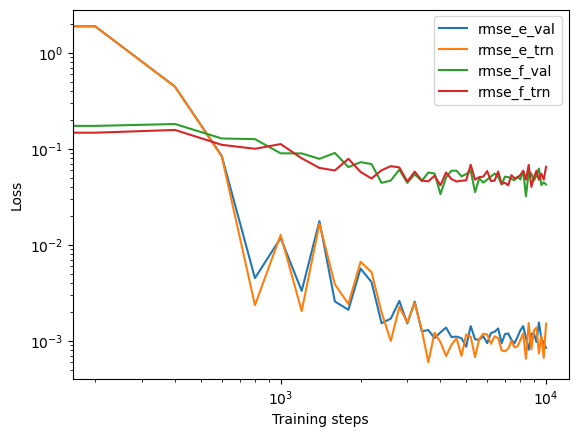

In [28]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
with open("lcurve.out") as f:
    headers = f.readline().split()[1:]
lcurve = pd.DataFrame(np.loadtxt("lcurve.out"), columns =  headers    )
legends = ["rmse_e_val", "rmse_e_trn", "rmse_f_val" , "rmse_f_trn" ]
for legend in legends:
    plt.loglog(lcurve["step"], lcurve[legend], label = legend )
plt.legend()
plt.xlabel("Training steps")
plt.ylabel("Loss")
plt.show()

## Freeze a model

At the end of the training, the model parameters saved in TensorFlow's checkpoint file should be frozen as a model file that is usually ended with extension .pb. Simply execute

In [29]:
! dp freeze -o graph.pb

2023-03-27 14:33:28.382205: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/mpi/gcc/openmpi-4.1.0rc5/lib:/usr/local/nccl-rdma-sharp-plugins/lib:/usr/local/nvidia/lib64:/usr/local/cuda/lib64:/usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-03-27 14:33:28.382354: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/mpi/gcc/openmpi-4.1.0rc5/lib:/usr/local/nccl-rdma-sharp-plugins/lib:/usr/local/nvidia/lib64:/usr/local/cuda/lib64:/usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-03-27 14:33:28.382373: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If 

and it will output a model file named `graph.pb` in the current directory. 

## Test a model 

We can check the quality of the trained model by running


In [30]:
! dp test -m graph.pb -s ../00.data/validation_data

2023-03-27 14:33:35.047134: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/mpi/gcc/openmpi-4.1.0rc5/lib:/usr/local/nccl-rdma-sharp-plugins/lib:/usr/local/nvidia/lib64:/usr/local/cuda/lib64:/usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-03-27 14:33:35.047280: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/mpi/gcc/openmpi-4.1.0rc5/lib:/usr/local/nccl-rdma-sharp-plugins/lib:/usr/local/nvidia/lib64:/usr/local/cuda/lib64:/usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-03-27 14:33:35.047298: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If 

The correlation between predicted data and original data can also be calculated.

In [31]:
import dpdata
training_systems = dpdata.LabeledSystem("../00.data/training_data", fmt = "deepmd/npy")

In [32]:
predict = training_systems.predict("graph.pb")

[]

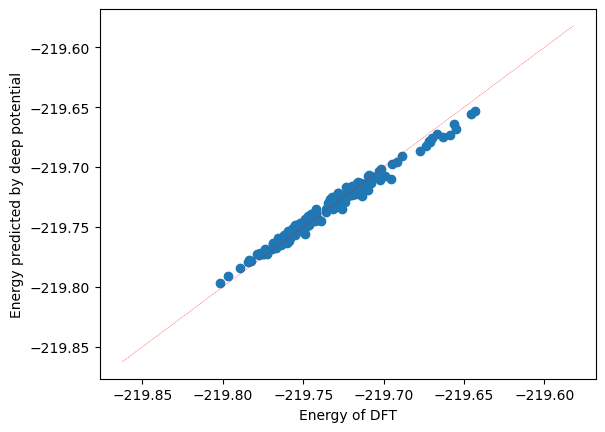

In [33]:
import matplotlib.pyplot as plt
import numpy as np
plt.scatter(training_systems["energies"], predict["energies"])
x_range = np.linspace(np.min(training_systems["energies"]) * 0.999, np.max(training_systems["energies"]) * 1.001, 20)
plt.plot(x_range, x_range, "r--", linewidth = 0.25)
plt.xlabel("Energy of DFT")
plt.ylabel("Energy predicted by deep potential")
plt.plot()

## Run MD with LAMMPS

The model can drive molecular dynamics in LAMMPS. 


In [34]:
! cd ../02.lmp && cp ../01.train/graph.pb ./ && ls

conf.lmp  graph.pb  in.lammps


Here `conf.lmp` gives the initial configuration of a gas phase methane MD simulation, and the file `in.lammps` is the lammps input script. One may check in.lammps and finds that it is a rather standard LAMMPS input file for a MD simulation, with only two exception lines:
```
pair_style  deepmd graph.pb
pair_coeff  * *
```
where the pair style deepmd is invoked and the model file `graph.pb` is provided, which means the atomic interaction will be computed by the DP model that is stored in the file `graph.pb`. 

In an environment with a compatibable version of LAMMPS, the deep potential molecular dynamics can be performed via 

```bash
lmp -i input.lammps
```